# Notebook #3: Queries, Visualización y Análisis

- En este tercer notebook realizaremos consultas sobre nuestra base de datos y las usaremos para generar visualizaciones y el análisis de las mismas.

- Las visualizaciones de Ploty no se renderizan en Github. Para poder verlas es necesaria la descarga del Notebook.

- A lo largo el notebook, los números con el formato "(1)" representan fuentes externas de información utilizadas, que se referencian al final de este notebook.

- El primer paso será importar las librerías necesarias:

In [3]:
# Librerías para tratamiento de datos
import pandas as pd
import geopandas as gpd
pd.set_option("display.max_columns", None) # Parámetro que modifica la visualización de los resultado3s
import numpy as np

# Trabajar con bases de datos SQL
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

# Librería para el acceso a variables y funciones
import sys
sys.path.append("../")
from src import soporte_funciones as sf #Archivo .py donde encontraremos todas nuestras funciones.

# Librería de mapas
import folium

# Librerías para graficar
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Librería para ignorar avisos
import warnings
warnings.filterwarnings("ignore") # Ignora TODOS los avisos

/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Objeto del Análisis 

- Antes de plantearnos las queries que pretendemos realizar, debemos recordar que el objetivo del proyecto es obtener insights sobre el mercado, así como la estructura de los datos.

- La información con la que contamos tiene relación con el mercado de la vivienda en Madrid, e incluye:
    - Datos de viviendas turísticas (AirBnB).
    - Datos de viviendas de alquiler (Idelista y Redpiso).
    - Datos sobre los ingresos por hogar (INE).
    - Datos sobre cantidad de población nacional y extranjera (Ayuntamiento de Madrid).

#### Diagrama Entidad Relación

<img src="../images/DiagramaER.png" width="400">

- Para ejecutar nuestras queries, haremos uso de la función `sf.dbeaver_fetch()`, que recibe como argumentos la conexión a DBeaver (usamos la función `sf.dbeaver_conexion()`) y la query.

### 1. Precio Promedio del Alquiler por Distrito

In [2]:
query1= '''
SELECT d.nombre, 
    round(AVG(i.precio),2) AS avg_precio_idealista, 
    round(AVG(r.precio),2) AS avg_precio_redpiso,
    round(AVG(i.precio)+AVG(r.precio)/2,2) AS alquiler_prom
FROM distritos d
INNER JOIN idealista i ON d.id_distrito = i.id_distrito
INNER JOIN redpiso r ON d.id_distrito = r.id_distrito
INNER JOIN airbnb a ON d.id_distrito = a.id_distrito
GROUP BY d.nombre
ORDER BY alquiler_prom DESC
;'''

In [3]:
resultado1 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query1)
resultado1

,nombre,avg_precio_idealista,avg_precio_redpiso,alquiler_prom
0,Retiro,2076.94,2027.65,3090.77
1,Salamanca,2362.96,1377.27,3051.60
2,Centro,2268.11,1088.95,2812.58
3,Chamberi,2085.52,1367.30,2769.17
4,Chamartin,1944.84,1211.45,2550.56
5,Moncloa-Aravaca,1850.08,1225.00,2462.58
6,Fuencarral-El Pardo,1788.85,1133.40,2355.55
7,Arganzuela,1734.50,1121.43,2295.21
8,Hortaleza,1703.57,1167.68,2287.41
9,Tetuan,1610.68,1161.00,2191.18


In [4]:
fig1 = px.bar(resultado1, x='nombre', y='alquiler_prom', 
             title='Precio Promedio de Alquiler por Distrito al 1 de Nov. de 2024',
             labels={'nombre': 'Distrito', 'alquiler_prom': 'Precio Promedio de Alquiler (€)'},
             color='nombre')
             #color_discrete_sequence=px.colors.sequential.Viridis)

fig1.update_traces(marker_color='skyblue', text=resultado1['alquiler_prom'], texttemplate='%{y:.2f}', textposition='outside')

fig1.show()

- La gráfica muestra el "Precio Promedio de Alquiler por Distrito al 1 de Nov. de 2024" en euros (€). En el eje vertical se encuentra el precio promedio de alquiler en euros, mientras que en el eje horizontal se listan los diferentes distritos. Los distritos están ordenados de mayor a menor precio promedio de alquiler.
- Encabezan la lista los distritos de Retiro: 3090.77 €, Salamanca: 3051.60 € y Centro: 2812.58 €.
- En el otro extremo, los distritos más baratos son Barajas: 1570.00 €, Puente de Vallecas: 1524.30 € y Carabanchel: 1399.50 €.

### 2. Porcentaje del Ingreso del Hogar dedicado al Alquiler

In [ ]:
query2='''
SELECT d.nombre, 
    round(AVG(i.precio)+AVG(r.precio)/2,2) AS alquiler_prom, 
    AVG(ih.total)/12 AS ingreso_prom_hogar,
    (AVG(i.precio)+AVG(r.precio)/2) / (AVG(ih.total)/12) AS porc_alquiler_ingreso
FROM distritos d
INNER JOIN idealista i ON d.id_distrito = i.id_distrito
INNER JOIN redpiso r ON d.id_distrito = r.id_distrito
INNER JOIN ingresos_hogar ih ON d.id_distrito = ih.id_distrito
GROUP BY d.nombre
ORDER BY porc_alquiler_ingreso DESC
;'''

In [55]:
resultado2 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query2)
resultado2

,nombre,alquiler_prom,ingreso_prom_hogar,porc_alquiler_ingreso
0,Centro,2812.58,2999.677083,0.937629
1,Tetuan,2191.18,3172.885417,0.690596
2,Usera,1621.43,2349.500000,0.690116
3,Puente de Vallecas,1524.30,2256.322917,0.675569
4,Latina,1800.28,2698.114583,0.667237
5,Retiro,3090.77,4637.322917,0.666498
6,Vicalvaro,1903.33,2895.270833,0.657394
7,Moratalaz,1982.50,3090.291667,0.641525
8,Ciudad Lineal,2082.83,3310.718750,0.629118
9,Arganzuela,2295.21,3684.468750,0.622943


In [7]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=resultado2['nombre'], y=resultado2['alquiler_prom'],
                         mode='lines+markers',
                         name='Precio Promedio de Alquiler'))
                         
fig2.add_trace(go.Scatter(x=resultado2['nombre'], y=resultado2['ingreso_prom_hogar'],
                         mode='lines+markers',
                         name='Ingreso Promedio por Hogar'))

fig2.update_layout(title='Precio Promedio de Alquiler vs. Ingreso Promedio por Hogar',
                  xaxis_title='Distrito',
                  yaxis_title='Euros',
                  xaxis_tickangle=-45)

fig2.show()

- La gráfica muestra la relación entre el Precio Promedio de Alquiler (línea azul) y el Ingreso Promedio por Hogar (línea roja) en diferentes distritos.
- En el eje vertical se indica el precio en euros, mientras que en el eje horizontal se listan los distritos.
- En algunos distritos como Salamanca y Chamartín, el ingreso promedio por hogar es significativamente más alto, mientras que el precio promedio de alquiler varía menos entre los distritos. Esto sugiere que en distritos con ingresos más altos, una menor proporción del ingreso se destina al alquiler en comparación con distritos con ingresos más bajos.

### 3. Identificación de outliers en precios de Idealista y Redpiso

In [8]:
query3 = '''
SELECT 
    'Idealista' AS fuente,
    precio 
FROM 
    idealista
UNION ALL
SELECT 
    'Redpiso' AS fuente,
    precio 
FROM 
    redpiso
;'''

In [9]:
resultado3 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query3)
resultado3

,fuente,precio
0,Idealista,1350
1,Idealista,2300
2,Idealista,1200
3,Idealista,3200
4,Idealista,750
...,...,...
920,Redpiso,1500
921,Redpiso,1500
922,Redpiso,1500
923,Redpiso,1500


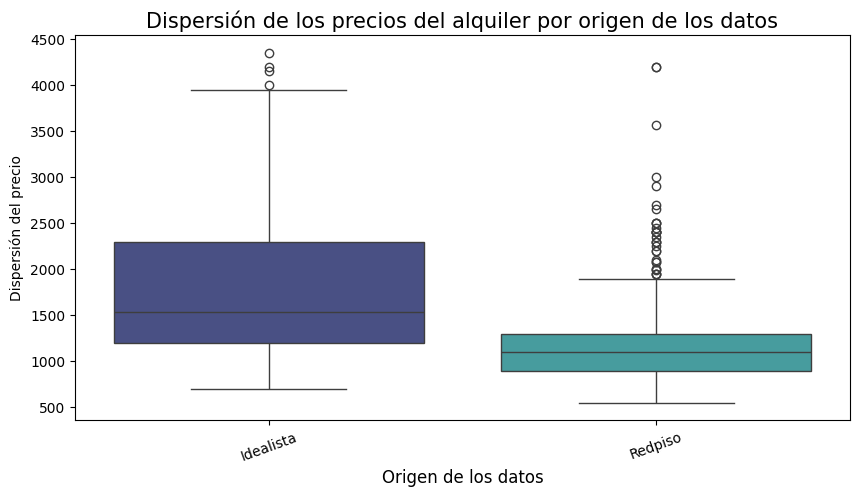

In [10]:
plt.figure(figsize = (10,5))
sns.boxplot(x = "fuente",
            y = "precio",
            data = resultado3, 
            palette = "mako",
            )


plt.xticks(rotation = 20)
plt.title("Dispersión de los precios del alquiler por origen de los datos", fontsize = 15)
plt.xlabel("Origen de los datos", fontsize = 12)
plt.ylabel("Dispersión del precio")

plt.show()

- La gráfica muestra la dispersión de los precios del alquiler por origen de los datos, comparando los precios de alquiler recogidos de Idealista y Redpiso.
- Al extraer los datos, hemos realizado ya un análisis de los outliers. En el caso de idealista, hemos eliminado 32 registros por alejarse mucho de la media, siendo alquileres de más de 5000 euros al mes. Para los datos de Redpiso, los outliers se encuentran aún en márgenes normales del mercado, con lo cual, hemos decidido mantener todos los registros.
- En el eje y se muestra la dispersión de los precios de alquiler, indicando el rango de precios. En las x, las fuentes de datos: idealista y Redpiso.

**Box Plot de idealista:**
- Rango Intercuartílico (IQR): Los precios varían aproximadamente entre 1000 y 2500 euros.
- Mediana: Alrededor de 1500 euros.
- Outliers: Se observan varios precios por encima de 4000 euros, indicando propiedades significativamente más caras.

**Box Plot de Redpiso:**
- Rango Intercuartílico (IQR): Los precios se encuentran entre 1000 y 1500 euros.
- Mediana: Cerca de 1250 euros.
- Outliers: Algunos precios superan los 2000 euros, pero son menos extremos que en Idealista.

**Comparativamente** los precios de alquiler en Idealista muestran una mayor variabilidad en comparación con Redpiso. Esto podría deberse a diferentes enfoques de recopilación de datos, tipos de propiedades listadas, mercado objetivo o áreas geográficas cubiertas.

### 4. Conteo de Anuncios de Alquiler por Distrito

In [5]:
query4 = '''
SELECT d.nombre, 
     (SELECT COUNT(*)
            FROM idealista i
            WHERE i.id_distrito = d.id_distrito) AS idealista, 
     (SELECT COUNT(*)
            FROM redpiso r
            WHERE r.id_distrito = d.id_distrito) AS redpiso, 
     (SELECT COUNT(*)
            FROM airbnb a
            WHERE a.id_distrito = d.id_distrito) AS airbnb,
     (SELECT COUNT(*)
            FROM idealista i
            WHERE i.id_distrito = d.id_distrito) + 
     (SELECT COUNT(*)
            FROM redpiso r
            WHERE r.id_distrito = d.id_distrito) AS total_alquileres
FROM distritos d;
;'''

In [6]:
resultado4 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query4)
resultado4

,nombre,idealista,redpiso,airbnb,total_alquileres
0,Centro,74,62,210,136
1,Arganzuela,20,35,29,55
2,Retiro,18,17,8,35
3,Salamanca,27,33,13,60
4,Chamartin,31,69,4,100
5,Tetuan,22,25,22,47
6,Chamberi,29,74,26,103
7,Fuencarral-El Pardo,13,47,1,60
8,Moncloa-Aravaca,26,26,6,52
9,Latina,16,31,3,47


In [13]:
fig4 = go.Figure()

fig4.add_trace(go.Scatter(x=resultado4['nombre'], y=resultado4['idealista'],
                         mode='lines+markers',
                         name='Idealista'))

fig4.add_trace(go.Scatter(x=resultado4['nombre'], y=resultado4['redpiso'],
                         mode='lines+markers',
                         name='Redpiso'))

fig4.add_trace(go.Scatter(x=resultado4['nombre'], y=resultado4['airbnb'],
                         mode='lines+markers',
                         name='Airbnb'))

fig4.update_layout(title='Cantidad de Anuncios por Fuente y Distrito',
                  xaxis_title='Distrito',
                  yaxis_title='Cantidad de Anuncios',
                  xaxis_tickangle=-45)

fig4.show()


- La gráfica muestra la cantidad de anuncios por fuente y por distrito de Madrid, según tres las fuentes consultadas: idealista, Redpiso y Airbnb.

- En el caso de idealista, podemos ver que la mayoría de los anuncios allí publicados corresponden con distritos de rentas más altas, aunque el distrito de Villa de Vallecas ocupa el segundo lugar en anuncios tras el distrito Centro. Esta distribución es consistente con que, la media de precios sea mayor a la de Redpiso. En general, tiene pisos repartidos por todos los distritos.

- Redpiso cuenta con una gran cantidad de anuncios publicados en los distritos de Centro, Chamartín, Chamberí, siendo estos barrios de mayor poder adquisitivo. También se muestra una gran cantidad en los barrios más obreros de Puente de Vallecas y Hortaleza.

- Los distritos con más disponibilidad de viviendas de alquiler según la consulta son: Centro (136), Chamberí (103) y Chamartín (100). En el otro extremo, Moratalaz, Usera, Barajas y Vicálvaro muestran menos de 10 anuncios publicados, lo que podría sugerir que el mercado del alquiler tiene características particulares en estos distritos.

- Respecto a los AirBnBs, el distrito centro destaca por la gran cantidad de anuncios, hasta 210. Le siguen Arganzuela, Chamberí y Tetuán. En el resto de distritos hay poca variabilidad en la cantidad de anuncios.

### 5. Cambio de la población en el período del 2018 al 2022

In [14]:
query5='''
SELECT d.nombre, 
       SUM(p.espanioles) AS total_espanoles, 
       SUM(p.extranjeros) AS total_extranjeros, 
       SUM(p.total) AS total_cambio
FROM distritos d
INNER JOIN poblacion p ON d.id_distrito = p.id_distrito
GROUP BY d.nombre
ORDER BY total_cambio DESC
;'''

In [15]:
resultado5 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query5)
resultado5

,nombre,total_espanoles,total_extranjeros,total_cambio
0,Hortaleza,6955,5965,12918
1,Carabanchel,-2868,14443,11574
2,Villaverde,1811,9439,11246
3,Villa de Vallecas,5306,5231,10543
4,Vicalvaro,6419,2820,9239
5,Puente de Vallecas,-5441,13529,8087
6,Centro,-1425,9189,7761
7,Fuencarral-El Pardo,3201,4434,7634
8,Usera,-1834,7862,6031
9,San Blas,-2606,7116,4509


In [16]:
fig5 = go.Figure()

fig5.add_trace(go.Scatter(x=resultado5['nombre'], y=resultado5['total_espanoles'],
                         mode='lines+markers',
                         name='Total Españoles'))

fig5.add_trace(go.Scatter(x=resultado5['nombre'], y=resultado5['total_extranjeros'],
                         mode='lines+markers',
                         name='Total Extranjeros'))

fig5.update_layout(title='Variación de Habitantes por Distrito entre el 2018 y el 2022 (Españoles vs. Extranjeros)',
                  xaxis_title='Distrito',
                  yaxis_title='Cantidad de Personas',
                  xaxis_tickangle=-45)

fig5.show()

- En esta gráfica se muestra la variación agregada en la cantidad de habitantes por distrito y por nacionalidad entre el año  2018 y el 2022.
- El eje Y representa la cantidad de personas, con un rango desde -5000 hasta 15000. La línea azul (Total Españoles) Indica la variación en el número total de españoles, y la roja (Total Extranjeros), indica la variación en el número total de extranjeros.
**Extranjeros:** Destaca sin duda el crecimiento de la población de extranjeros, que ha aumentado en todos los distritos. En varios distritos, especialmente en aquellos con una línea roja más alta, se observa un aumento significativo en la población extranjera. Por ejemplo, distritos como Carabanchel, Villaverde, Puente de Vallecas y Latina muestran un notable incremento en extranjeros, siendo distritos de clase obrera. En el caso de aquellos con mayores ingresos, destaca Salamanca, que añade unos 5 mil habitantes.

**Españoles:** A simple vista, tenemos el fenómeno contrario frente a los extranjeros. En muchos distritos, la cantidad de españoles se reduce. Las mayores caídas registradas en Carabanchel, Puente de Vallecas y Latina, que pierde casi 7 mil habitantes en el período. Aumenta significativamente la población en Vicálvaro y Hortaleza.

**Contraste entre Nacionales y Extranjeros:** En la mayoría de distritos, hay un notable contraste entre el crecimiento de españoles y extranjeros. Esto podría indicar tendencias de migración o cambios en la demografía local. Pareciera que, donde llegan los extranjeros, los españoles se van.

- Esta gráfica es crucial para entender las dinámicas demográficas de los diferentes distritos de Madrid. Sería necesaria una investigación más profunda que determine las causas.

### 6. Relación entre nacionalidad en el año 2022 y AirBnBs por distrito

In [ ]:
query6 = '''
WITH Airbnb AS (
    SELECT id_distrito, COUNT(*) AS cantidad_airbnbs 
    FROM airbnb 
    GROUP BY id_distrito
),
Poblacion AS (
    SELECT id_distrito, SUM(espanioles) AS var_espanoles, SUM(extranjeros) AS var_extranjeros 
    FROM poblacion 
    GROUP BY id_distrito
),
Idealista AS (
    SELECT id_distrito, AVG(precio) AS precio_idealista 
    FROM idealista 
    GROUP BY id_distrito
),
Redpiso AS (
    SELECT id_distrito, AVG(precio) AS precio_redpiso 
    FROM redpiso 
    GROUP BY id_distrito
)

SELECT 
    d.nombre AS distrito, 
    (AVG(i.precio_idealista) + AVG(r.precio_redpiso)) / 2 AS precio_medio_alquiler, 
    p.var_espanoles, 
    p.var_extranjeros,
    a.cantidad_airbnbs
FROM 
    distritos d
LEFT JOIN 
    Poblacion p ON d.id_distrito = p.id_distrito
LEFT JOIN 
    Idealista i ON d.id_distrito = i.id_distrito
LEFT JOIN 
    Redpiso r ON d.id_distrito = r.id_distrito
LEFT JOIN 
    Airbnb a ON d.id_distrito = a.id_distrito
GROUP BY 
    d.nombre, p.var_espanoles, p.var_extranjeros, a.cantidad_airbnbs
ORDER BY
    var_extranjeros DESC, var_espanoles DESC

;'''

In [25]:
resultado6 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query6)
resultado6

,distrito,precio_medio_alquiler,var_espanoles,var_extranjeros,cantidad_airbnbs
0,Carabanchel,943.5000000000000000,-2868,14443,7.0
1,Puente de Vallecas,985.5523255813953489,-5441,13529,12.0
2,Latina,1167.1572580645161291,-6660,9957,3.0
3,Villaverde,1003.1250000000000000,1811,9439,NaN
4,Centro,1678.5298605056669573,-1425,9189,210.0
5,Usera,1060.7142857142857143,-1834,7862,NaN
6,San Blas,1202.1818181818181818,-2606,7116,4.0
7,Ciudad Lineal,1353.6666666666666667,-5517,6998,5.0
8,Hortaleza,1435.6266233766233766,6955,5965,5.0
9,Salamanca,1870.1178451178451179,-3960,5654,13.0


In [35]:
fig6 = go.Figure()

# Añade las barras para 'Precio Medio del Alquiler'
fig6.add_trace(go.Bar(
    x=resultado6['distrito'], 
    y=resultado6['precio_medio_alquiler'],
    name='Precio Medio Alquiler',
    yaxis='y2',
    marker_color='skyblue',
    opacity=0.4
))

fig6.add_trace(go.Scatter(
    x=resultado6['distrito'], 
    y=resultado6['var_espanoles'],
    mode='lines+markers',
    name='Variación de Españoles',
    yaxis='y1',
    line=dict(color='red', width=2)
))

fig6.add_trace(go.Scatter(
    x=resultado6['distrito'], 
    y=resultado6['var_extranjeros'],
    mode='lines+markers',
    name='Variación de Extranjeros',
    yaxis='y1',
    line=dict(color='green', width=2)
))

fig6.add_trace(go.Scatter(
    x=resultado6['distrito'], 
    y=resultado6['cantidad_airbnbs'],
    mode='lines+markers',
    name='Cantidad de Airbnbs',
    yaxis='y1',
    line=dict(color='purple', width=2)
))

# Configurar el layout para ejes dobles
fig6.update_layout(
    title='Análisis por Distrito',
    xaxis=dict(title='Distrito'),
    yaxis=dict(
        title='Variación de Habitantes y Cantidad de Airbnbs',
        titlefont=dict(color='black'),
        tickfont=dict(color='black')
    ),
    yaxis2=dict(
        title='Precio Medio Alquiler (€)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        anchor='x',
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=1.1,  # Mueve la leyenda fuera del gráfico
        y=1,
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='rgba(255,255,255,0.5)'
    ),
    barmode='group'  # Agrupa las barras
)


fig6.show()


- Con esta última gráfica, resumimos de manera visual el contenido de los datos extraídos y tratados. Proporciona una visión más completa del mercado de alquiler y las dinámicas demográficas en los diferentes distritos de Madrid.

- Salamanca, Chamberí y Chamartín: Estos distritos tienen los precios de alquiler más altos. Esto podría deberse a la calidad de las viviendas, la ubicación céntrica y las comodidades disponibles. Estos distritos probablemente ofrecen una alta calidad de vida y mejores servicios.

- Villaverde y Villa de Vallecas: Estos distritos tienen los precios de alquiler más bajos. Estos podrían ser atractivos para inquilinos con presupuestos más bajos. Sugiere menos desarrollo en comparación con distritos más caros.

- Distritos como Centro y Chamberí muestran disminuciones significativas en la población española. Las disminuciones pueden sugerir que estos lugares se están volviendo menos atractivos para los residentes locales, posiblemente debido a la alta afluencia de extranjeros y turistas.

- Distritos como Vicálvaro y Hortaleza muestran incrementos positivos en la población española, indicando una posible preferencia de la población local por estas áreas.

- Centro y Chamberí destacan con aumentos significativos en la población extranjera, sugiriendo que estas áreas son populares entre los expatriados, y reflejan su atractivo internacional.

- Algunos distritos como Puente de Vallecas y Villaverde también muestran incrementos notables en extranjeros, lo cual puede estar relacionado con factores de accesibilidad o nuevas oportunidades.

- El distrito Centro destaca por tener la mayor cantidad de Airbnbs, lo que refleja su popularidad entre los turistas. La alta cantidad de apartamentos turísticos puede influir en la disponibilidad de viviendas para alquileres a largo plazo y poner presión sobre los precios.

- Barajas y Villaverde tienen pocos Airbnbs, indicando una orientación más residencial. Ofrecen un entorno más estable y posiblemente más atractivo para residentes permanentes debido a la menor competencia con el turismo.

### 7. Precio medio de 2 noches de AirBnB
- Fechas consultadas: 31 de enero al 2 de febrero de 2025 para 2 adultos.

In [20]:
query7='''
SELECT 
    round(AVG(precio),2) AS precio_promedio_airbnb
FROM 
    airbnb;
'''

In [21]:
resultado7 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query7)
resultado7

,precio_promedio_airbnb
0,243.21


## Nuevo GeoJson distritos

- Dado que contamos con nueva información sobre los ingresos y el precio promedio del alquiler para cada distrito, nos interesa combinar esa información en un mismo dataframe, que servirá para alimentar el mapa que crearemos como último paso.
- Primero hacemos la query a nuestra tabla "distritos".

In [41]:
query8='''
SELECT 
    id_distrito, nombre, ST_AsText(geometry) AS geometry
FROM 
    distritos;
'''

- Creamos un DF que transformamos a geodataframe, para mantener el tipo geometría.

In [43]:
resultado8 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query8)
gdf_distritos = gpd.GeoDataFrame(resultado8, geometry=gpd.GeoSeries.from_wkt(resultado8['geometry']))
gdf_distritos.dtypes

id_distrito       int64
nombre           object
geometry       geometry
dtype: object

- Y lo unimos por la columa "nombre" con el resultado de la query #2.

In [58]:
gdf_distritos_merge = pd.merge(gdf_distritos, resultado2, on='nombre', how='inner')
gdf_distritos_merge.drop(columns = "porc_alquiler_ingreso", inplace=True)
gdf_distritos_merge["ingreso_prom_hogar"] = gdf_distritos_merge["ingreso_prom_hogar"].round(2)
gdf_distritos_merge.head(1)

,id_distrito,nombre,geometry,alquiler_prom,ingreso_prom_hogar
0,1,Centro,"MULTIPOLYGON (((-3.69185 40.40853, -3.69189 40...",2812.58,2999.68


- Guardamos a un archivo `geojson.`

In [ ]:
#gdf_distritos_merge.to_file('../datos/finales/distritos_mapa.geojson', driver='GeoJSON')

## Mapa
- Dado que contamos con información geográfica de las ubicaciones de los alojamientos turísticos y las viviendas en alquiler, nos interesa poder mostrarla en un mapa, que será de fácil consulta.
- Para ello utilizaremos la librería Folium.
- Como primer paso, debemos crear un nuevo mapa, en este caso, con inicio en las coordenadas de Madrid capital.

In [67]:
map = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

- A continuación, insertaremos la información de los archivos `geojson` que habíamos generado en el primer notebook para lo AirBnBs y alquileres de idealista, así como el dataframe de distritos que acabamos de crear. Así, deslizando sobre el mapa, tendremos información de precios e ingresos promedio por distrito.

In [68]:
geojson_distritos = gpd.read_file("../datos/finales/distritos_mapa.geojson")
folium.GeoJson(
    geojson_distritos,
    style_function=sf.estilos_mapa,
    tooltip=folium.features.GeoJsonTooltip(fields=['id_distrito', 'nombre', 'alquiler_prom', 'ingreso_prom_hogar']) 
).add_to(map)

In [69]:
geojson_airbnb = gpd.read_file("../datos/finales/airbnb.geojson")
folium.GeoJson(
    geojson_airbnb,
    tooltip=folium.features.GeoJsonTooltip(fields=['Precio Total', 'Descripcion'], aliases=['Precio AirBnB: ', 'Descripción'])
).add_to(map)

# Cambiamos aspecto de marcadores para diferenciarlos de las viviendas de alquiler
for idx, row in geojson_airbnb.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        tooltip=f"**AIRBNB** Precio: {row['Precio Total']}<br>Descripción: {row['Descripcion']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map)

In [70]:
geojson_idealista = gpd.read_file("../datos/finales/idealista.geojson")
folium.GeoJson(
    geojson_idealista,
    tooltip=folium.features.GeoJsonTooltip(fields=['Precio', 'Tipo', 'Planta', 'Tamanio', 'Habitaciones', 'Banios', 'Direccion', 'Descripcion']) 
).add_to(map)

- En el mapa, es posible visualizar los distritos de Madrid, en azul las viviendas en alquiler y en rojo los AirBnBs. Deslizando sobre cada uno podemos consultar la información de esa vivienda o alojamiento.

In [71]:
map

- El último paso será guardarlo en un archivo de tipo `html` para fácil consulta.

In [ ]:
#map.save('../datos/finales/mapa_madrid.html')

## Conclusiones

- El mercado de alquiler en Madrid presenta una clara segmentación geográfica influida por factores como el precio, el perfil demográfico y la presencia de turistas. Distritos como Retiro, Salamanca, Chamberí y Chamartín se destacan por tener los alquileres más altos, probablemente debido a su ubicación céntrica, la calidad de sus viviendas y la disponibilidad de servicios y comodidades que elevan la calidad de vida. Por otro lado, áreas como Villaverde y Villa de Vallecas, con precios significativamente más bajos, resultan atractivas para quienes tienen un presupuesto limitado, reflejando una menor demanda y un desarrollo urbano más modesto. Esta variabilidad de precios no solo responde a las características de cada distrito, sino también a la afluencia de turistas y residentes temporales, que contribuyen a una demanda fluctuante en ciertas zonas.

- Además, el análisis demográfico revela cambios significativos en la composición de los residentes. Distritos como Centro y Chamberí muestran una disminución en la población española, posiblemente debido al incremento en el número de turistas y expatriados que encuentran en estas áreas una opción atractiva para residir temporalmente, como lo sugiere la alta cantidad de Airbnbs. A su vez, distritos más residenciales como Barajas y Villaverde, con menos presencia de apartamentos turísticos, ofrecen un entorno más estable y orientado a residentes permanentes. Por el contrario, áreas como Vicálvaro y Hortaleza están viendo un aumento en la población local, lo que podría indicar una preferencia de los madrileños por zonas menos afectadas por el turismo, mientras que la afluencia de extranjeros en distritos accesibles como Puente de Vallecas y Villaverde sugiere que estas áreas siguen siendo atractivas para una comunidad diversa.

- Los datos obtenidos en este proyecto podrían ser de uso para las autoridades políticas, encargadas de la planificación, que pueden usarlos para equilibrar la oferta y demanda de viviendas, tanto para locales como extranjeros. También sería de interés para los inversionistas, pudiendo identificar áreas con alto crecimiento y demanda, ajustando sus estrategias de inversión para maximizar el retorno. Y no menos importante, para residentes y potenciales inquilinos, aporta pistas sobre las dinámicas de cada distrito, ayudándoles a tomar decisiones informadas sobre dónde vivir.

### Próximos Pasos
- Ampliar la muestra de pisos en alquiler y AirBnBs.
- Obtener información más reciente sobre la composición demográfica de los distritos.
- Nutrir la base de datos con otras variables que puedan tener influencia sobre los precios del alquiler.